# **Problem 4: Missing Value Imputation using Conditional-GAN**

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset
import glob 
import pickle
from collections import defaultdict
from torchvision.datasets import MNIST

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# This chunck of code is taken from here: https://gist.github.com/y0ast/f69966e308e549f013a92dc66debeeb4
class FastMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Scale data to [0,1]
        self.data = self.data.unsqueeze(1).float().div(255)
        
        # Normalize it with the usual MNIST mean and std
        self.data = self.data.sub_(0.5).div_(0.5)
        
        # Put both data and targets on GPU in advance
        self.data, self.targets = self.data.to(device), self.targets.to(device)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        return img, target

In [3]:
train_dataset = FastMNIST('data/MNIST', train=True, download=True)
test_dataset = FastMNIST('data/MNIST', train=False, download=True)

# check the shape of the dataset
print("shape before: ") 
print(train_dataset.data.shape, test_dataset.data.shape)
print(train_dataset.data.max(), train_dataset.data.min())

Extracting data/MNIST/FastMNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/FastMNIST/raw


Extracting data/MNIST/FastMNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/FastMNIST/raw


Extracting data/MNIST/FastMNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/FastMNIST/raw


Extracting data/MNIST/FastMNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/FastMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


shape before: 
torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])
tensor(1., device='cuda:0') tensor(-1., device='cuda:0')


In [4]:
extra = utils.DataLoader(train_dataset, batch_size=100, shuffle=True)
train_loader = utils.DataLoader(train_dataset, batch_size=100, shuffle=True)

print("\nChecking train loader:")
a, b = next(iter(train_loader))
print(a.shape, b.shape)

print("\nChecking extra loader:")
a, b = next(iter(extra))
print(a.shape, b.shape)


Checking train loader:
torch.Size([100, 1, 28, 28]) torch.Size([100])

Checking extra loader:
torch.Size([100, 1, 28, 28]) torch.Size([100])


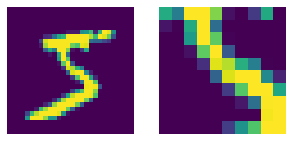

In [5]:
# print patched mnist example
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize=(5,5))
axes[0].imshow(train_dataset.data[0].cpu().numpy().reshape(28,28))
axes[0].axis('off')
axes[1].imshow(train_dataset.data[0, :, 9:19, 9:19].cpu().numpy().reshape(10, 10))
axes[1].axis('off')
fig.show()

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

        # dropout with probability 0.4
        self.drop = nn.Dropout(p=0.3)
    
    def forward(self, input):
        x = self.drop(F.relu(self.fc1(input)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        x = self.drop(F.relu(self.fc4(x)))
        x = torch.sigmoid(self.out(x)) # (100, 1)
        return x.squeeze()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(200, 400)
        self.fc2 = nn.Linear(400, 600)
        self.out = nn.Linear(600, 784)
    
    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.out(x))
        # x = x.view(x.size(0), 1, 28, 28)
        return x

In [7]:
def get_discriminator_input(img, fi):
    disc_img = torch.vstack((fi.detach(), img)) # (200, 784)
    disc_labels = torch.Tensor([0] * 100 + [1] *100).reshape(-1, 1).to(device)

    indices = torch.randperm(len(disc_img))
    disc_img = disc_img[indices]
    disc_labels = disc_labels[indices]
    return disc_img, disc_labels

### **Baseline: Training GAN without regularization**

In [11]:
d = Discriminator().to(device)
g = Generator().to(device)

# optimizers
d_opt = optim.Adam(d.parameters(), lr=1e-4)
g_opt = optim.Adam(g.parameters(), lr=1e-4)

# loss function
err_func = nn.BCELoss()

epochs = 150
batch_size = 100

for e in range(1, epochs+1):
    gloss_epoch, dloss_epoch = [], []
    for data, targets in train_loader:
        real_patch = data[:, :, 9:19, 9:19].reshape(-1, 100)

        noise_vector = torch.randn(batch_size, 100).to(device)
        gen_input = torch.hstack((noise_vector, real_patch)) # input to generator (B x 200)

        g.train()

        # training discriminator
        d_opt.zero_grad()
        fake_imgs = g(gen_input) # (100, 784)

        sampled_imgs = next(iter(extra))[0].reshape(-1, 784)
        d_ip_images, d_ip_labels = get_discriminator_input(sampled_imgs, fake_imgs) # torch.Size([200, 784]) torch.Size([200, 1])
        
        # Prediction on real images
        d_prediction = d(d_ip_images)
        d_loss = err_func(d_prediction, d_ip_labels.squeeze())
        
        d_loss.backward()
        d_opt.step()


        # training generator
        g_opt.zero_grad()

        noise_vector = torch.randn(batch_size, 100).to(device)
        gen_input = torch.hstack((noise_vector, real_patch)) # input to generator (B x 200)
        fake_imgs = g(gen_input)
        
        g_predictions = d(fake_imgs)
        fake_imgs_patch = fake_imgs.reshape(-1, 28, 28)[:, 9:19, 9:19].reshape(-1, 100)
        g_loss = err_func(g_predictions, torch.ones_like(g_predictions))

        g_loss.backward()
        g_opt.step()

        # calculate losses for both G and D
        gloss_epoch.append(g_loss.item())
        dloss_epoch.append(d_loss.item())
    if e % 5 == 0:
        print("Epoch: {eps}  |  D loss: {dl}  |  G loss: {gl}".format(eps=e, dl=np.mean(dloss_epoch), gl=np.mean(gloss_epoch) ))

Epoch: 5  |  D loss: 0.14139331117272377  |  G loss: 3.5587712371349336
Epoch: 10  |  D loss: 0.28653044556578  |  G loss: 2.238668064276377
Epoch: 15  |  D loss: 0.37289899890621503  |  G loss: 1.8263944731156032
Epoch: 20  |  D loss: 0.3980989922583103  |  G loss: 1.6881524300575257
Epoch: 25  |  D loss: 0.46505854234099386  |  G loss: 1.4104486684004465
Epoch: 30  |  D loss: 0.5032506108283996  |  G loss: 1.2679506687323252
Epoch: 35  |  D loss: 0.5167416221896808  |  G loss: 1.2272883306940396
Epoch: 40  |  D loss: 0.5414501595497131  |  G loss: 1.1450603370865187
Epoch: 45  |  D loss: 0.5528718628982703  |  G loss: 1.1286401898662248
Epoch: 50  |  D loss: 0.5751213423907757  |  G loss: 1.043275274236997
Epoch: 55  |  D loss: 0.575831792106231  |  G loss: 1.0787105735143026
Epoch: 60  |  D loss: 0.591577085951964  |  G loss: 0.9994202294945717
Epoch: 65  |  D loss: 0.5976871443788211  |  G loss: 0.9889917472998301
Epoch: 70  |  D loss: 0.6055307853221893  |  G loss: 0.9439779000480

In [12]:
# getting examples from each class
test_examples = []
for i in range(10):
    class_imgs = train_dataset.data[train_dataset.targets == i]
    idx = torch.randperm(len(class_imgs))
    class_imgs = class_imgs[idx]
    test_examples.append(class_imgs[:10].cpu().numpy())
test_examples = torch.Tensor(np.concatenate(test_examples, axis=0)).to(device)
print(test_examples.shape)

torch.Size([100, 1, 28, 28])


In [13]:
# testing
g.eval()
with torch.no_grad():
    noise_vector = torch.randn((100, 100)).to(device)
    test_patch = test_examples[:, : , 9:19, 9:19].reshape(-1, 100)
    gen_input = torch.hstack((noise_vector, test_patch))
    generated_examples = g(gen_input)
    generated_examples = generated_examples.cpu().numpy().reshape(-1, 1, 28, 28)
print(generated_examples.shape)

(100, 1, 28, 28)


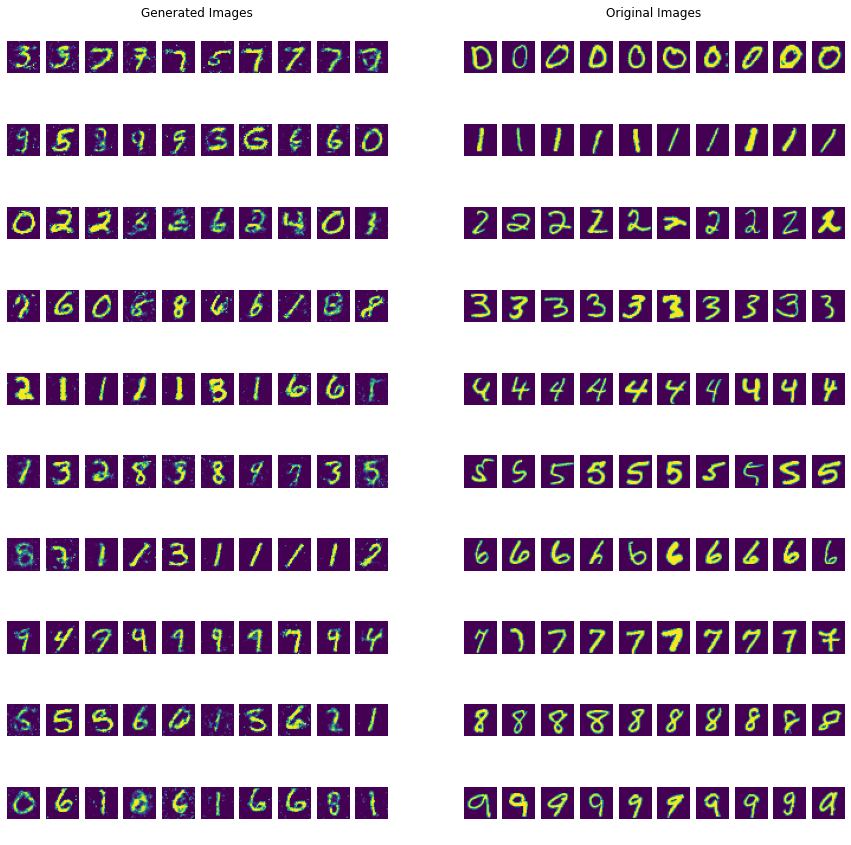

In [14]:
# https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
# https://matplotlib.org/3.1.0/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py

test_examples = test_examples.cpu().numpy()

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 15))

spec = gridspec.GridSpec(ncols=2, nrows=1, hspace=10)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax1.set_title("Generated Images")
ax2.set_title("Original Images")
ax1.axis('off')
ax2.axis('off')

left = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[0]) # plot for generated images
right = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[1]) # plot for original images
for c in range(100):
    ax = plt.Subplot(fig, left[c])
    ax.imshow(generated_examples[c].squeeze())
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.add_subplot(ax)

    ax = plt.Subplot(fig, right[c])
    ax.imshow(test_examples[c].squeeze())
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.add_subplot(ax)
plt.show()

As we can see we have generated some MNIST looking digits using the base model without regularization. As expected, the results are generated randomly, ignoring the conditioning vector. Next we will apply regualization with $\lambda$ = 0.1 and $\lambda$ = 10

### **Lambda = 0.1**

Training GAN with regularization with $\lambda$ = 0.1

In [15]:
d = Discriminator().to(device)
g = Generator().to(device)

# optimizers
d_opt = optim.Adam(d.parameters(), lr=1e-4)
g_opt = optim.Adam(g.parameters(), lr=1e-4)

extra = utils.DataLoader(train_dataset, batch_size=100, shuffle=True)

# loss function
err_func = nn.BCELoss()
mse = nn.MSELoss()

epochs = 150
batch_size = 100
lambda_ = 0.1

for e in range(1, epochs+1):
    gloss_epoch, dloss_epoch = [], []
    for data, targets in train_loader:
        real_patch = data[:, :, 9:19, 9:19].reshape(-1, 100)

        noise_vector = torch.randn(batch_size, 100).to(device)
        gen_input = torch.hstack((noise_vector, real_patch)) # input to generator (B x 200)

        g.train()

        # training discriminator
        d_opt.zero_grad()
        fake_imgs = g(gen_input) # (100, 784)

        sampled_imgs = next(iter(extra))[0].reshape(-1, 784)
        d_ip_images, d_ip_labels = get_discriminator_input(sampled_imgs, fake_imgs) # torch.Size([200, 784]) torch.Size([200, 1])
        
        # Prediction on real images
        d_prediction = d(d_ip_images)
        d_loss = err_func(d_prediction, d_ip_labels.squeeze())
        
        d_loss.backward()
        d_opt.step()

        # training generator
        g_opt.zero_grad()

        noise_vector = torch.randn(batch_size, 100).to(device)
        gen_input = torch.hstack((noise_vector, real_patch)) # input to generator (B x 200)
        fake_imgs = g(gen_input)
        
        g_predictions = d(fake_imgs)
        fake_imgs_patch = fake_imgs.reshape(-1, 28, 28)[:, 9:19, 9:19].reshape(-1, 100)
        g_loss = err_func(g_predictions, torch.ones_like(g_predictions)) + lambda_ * mse(real_patch, fake_imgs_patch)

        g_loss.backward()
        g_opt.step()

        # calculate losses for both G and D
        gloss_epoch.append(g_loss.item())
        dloss_epoch.append(d_loss.item())
    if e % 10 == 0:
        print("Epoch: {eps}  |  D loss: {dl}  |  G loss: {gl}".format(eps=e, dl=np.mean(dloss_epoch), gl=np.mean(gloss_epoch) ))

Epoch: 10  |  D loss: 0.40811999117334685  |  G loss: 1.842657189766566
Epoch: 20  |  D loss: 0.5498823241392772  |  G loss: 1.230098189910253
Epoch: 30  |  D loss: 0.6048407276471456  |  G loss: 1.0317953045169512
Epoch: 40  |  D loss: 0.6310350784659385  |  G loss: 0.9464406890670458
Epoch: 50  |  D loss: 0.6618107826511065  |  G loss: 0.8544400510191917
Epoch: 60  |  D loss: 0.6601339443524679  |  G loss: 0.8401360261440277
Epoch: 70  |  D loss: 0.6741784220933914  |  G loss: 0.7856171143054962
Epoch: 80  |  D loss: 0.676551865041256  |  G loss: 0.7664020835359892
Epoch: 90  |  D loss: 0.6830605491995811  |  G loss: 0.7407663092017174
Epoch: 100  |  D loss: 0.6854464200139045  |  G loss: 0.7442261942227681
Epoch: 110  |  D loss: 0.6858074905474981  |  G loss: 0.7304922620455424
Epoch: 120  |  D loss: 0.6865151576201121  |  G loss: 0.7367071896791458
Epoch: 130  |  D loss: 0.6861277707417806  |  G loss: 0.7288322928547859
Epoch: 140  |  D loss: 0.6842577556769053  |  G loss: 0.734917

In [16]:
# getting examples from each class
test_examples = []
for i in range(10):
    class_imgs = train_dataset.data[train_dataset.targets == i]
    idx = torch.randperm(len(class_imgs))
    class_imgs = class_imgs[idx]
    test_examples.append(class_imgs[:10].cpu().numpy())
test_examples = torch.Tensor(np.concatenate(test_examples, axis=0)).to(device)
print(test_examples.shape)

torch.Size([100, 1, 28, 28])


In [17]:
# testing
g.eval()
with torch.no_grad():
    noise_vector = torch.randn((100, 100)).to(device)
    test_patch = test_examples[:, : , 9:19, 9:19].reshape(-1, 100)
    gen_input = torch.hstack((noise_vector, test_patch))
    generated_examples = g(gen_input)
    generated_examples = generated_examples.cpu().numpy().reshape(-1, 1, 28, 28)
print(generated_examples.shape)

(100, 1, 28, 28)


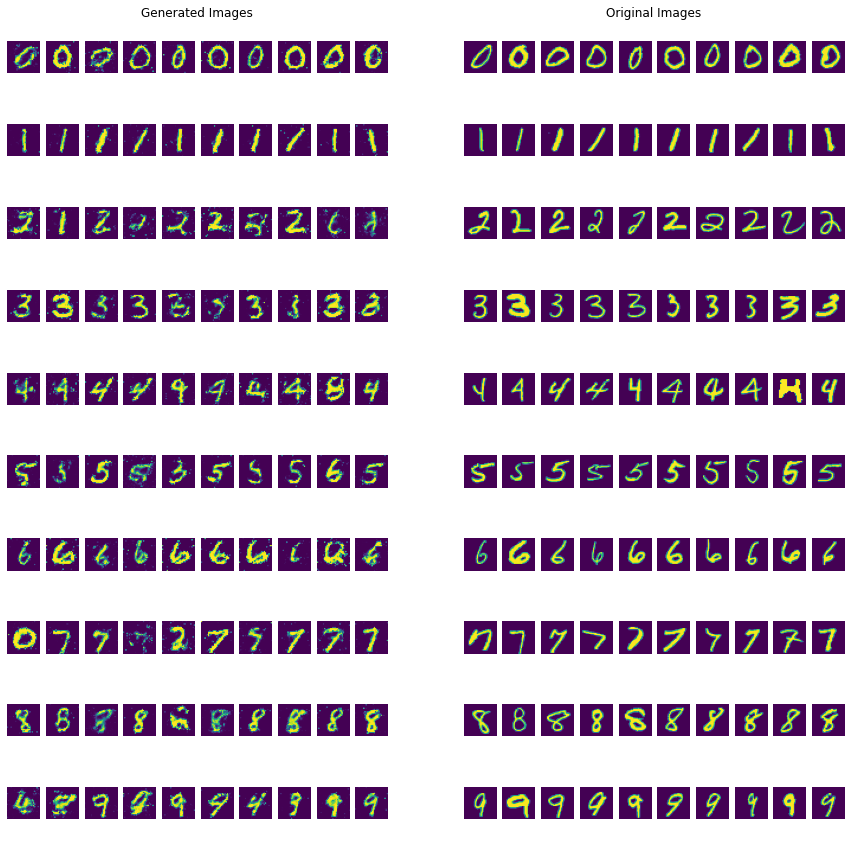

In [18]:
# https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
# https://matplotlib.org/3.1.0/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py

test_examples = test_examples.cpu().numpy()

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 15))

spec = gridspec.GridSpec(ncols=2, nrows=1, hspace=10)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax1.set_title("Generated Images")
ax2.set_title("Original Images")
ax1.axis('off')
ax2.axis('off')

left = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[0]) # plot for generated images
right = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[1]) # plot for original images
for c in range(100):
    ax = plt.Subplot(fig, left[c])
    ax.imshow(generated_examples[c].squeeze())
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.add_subplot(ax)

    ax = plt.Subplot(fig, right[c])
    ax.imshow(test_examples[c].squeeze())
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.add_subplot(ax)
plt.show()

### **Lambda = 10**

Training GAN with regularization with $\lambda$ = 10

In [19]:
d = Discriminator().to(device)
g = Generator().to(device)

# optimizers
d_opt = optim.Adam(d.parameters(), lr=1e-4)
g_opt = optim.Adam(g.parameters(), lr=1e-4)

extra = utils.DataLoader(train_dataset, batch_size=100, shuffle=True)

# loss function
err_func = nn.BCELoss()
mse = nn.MSELoss()

epochs = 150
batch_size = 100
lambda_ = 10

for e in range(1, epochs+1):
    gloss_epoch, dloss_epoch = [], []
    for data, targets in train_loader:
        real_patch = data[:, :, 9:19, 9:19].reshape(-1, 100)

        noise_vector = torch.randn(batch_size, 100).to(device)
        gen_input = torch.hstack((noise_vector, real_patch)) # input to generator (B x 200)

        g.train()

        # training discriminator
        d_opt.zero_grad()
        fake_imgs = g(gen_input) # (100, 784)

        sampled_imgs = next(iter(extra))[0].reshape(-1, 784)
        d_ip_images, d_ip_labels = get_discriminator_input(sampled_imgs, fake_imgs) # torch.Size([200, 784]) torch.Size([200, 1])
        
        # Prediction on real images
        d_prediction = d(d_ip_images)
        d_loss = err_func(d_prediction, d_ip_labels.squeeze())
        
        d_loss.backward()
        d_opt.step()


        # training generator
        g_opt.zero_grad()

        noise_vector = torch.randn(batch_size, 100).to(device)
        gen_input = torch.hstack((noise_vector, real_patch)) # input to generator (B x 200)
        fake_imgs = g(gen_input)
        
        g_predictions = d(fake_imgs)
        fake_imgs_patch = fake_imgs.reshape(-1, 28, 28)[:, 9:19, 9:19].reshape(-1, 100)
        g_loss = err_func(g_predictions, torch.ones_like(g_predictions)) + lambda_ * mse(real_patch, fake_imgs_patch)

        g_loss.backward()
        g_opt.step()

        # calculate losses for both G and D
        gloss_epoch.append(g_loss.item())
        dloss_epoch.append(d_loss.item())
    if e%10 == 0:
        print("Epoch: {eps}  |  D loss: {dl}  |  G loss: {gl}".format(eps=e, dl=np.mean(dloss_epoch), gl=np.mean(gloss_epoch) ))

Epoch: 10  |  D loss: 0.39540547246734303  |  G loss: 2.387708903551102
Epoch: 20  |  D loss: 0.5129687297840914  |  G loss: 1.6195886454979578
Epoch: 30  |  D loss: 0.5629541858037312  |  G loss: 1.3303981437285741
Epoch: 40  |  D loss: 0.6011270280679067  |  G loss: 1.1728074382742246
Epoch: 50  |  D loss: 0.616429613729318  |  G loss: 1.103395889500777
Epoch: 60  |  D loss: 0.6282609955469767  |  G loss: 1.050159874757131
Epoch: 70  |  D loss: 0.6408670739332835  |  G loss: 0.9845010047157605
Epoch: 80  |  D loss: 0.6536626845598221  |  G loss: 0.9528426389892896
Epoch: 90  |  D loss: 0.6528395146131516  |  G loss: 0.9425597067674001
Epoch: 100  |  D loss: 0.6588464245200157  |  G loss: 0.8905349323153495
Epoch: 110  |  D loss: 0.6657987774411838  |  G loss: 0.8878461570541064
Epoch: 120  |  D loss: 0.671649768948555  |  G loss: 0.8525182032585144
Epoch: 130  |  D loss: 0.6699152741829554  |  G loss: 0.8311950505773227
Epoch: 140  |  D loss: 0.6892456602056821  |  G loss: 0.80373645

In [20]:
# getting examples from each class
test_examples = []
for i in range(10):
    class_imgs = train_dataset.data[train_dataset.targets == i]
    idx = torch.randperm(len(class_imgs))
    class_imgs = class_imgs[idx]
    test_examples.append(class_imgs[:10].cpu().numpy())
test_examples = torch.Tensor(np.concatenate(test_examples, axis=0)).to(device)
print(test_examples.shape)

torch.Size([100, 1, 28, 28])


In [21]:
# testing
g.eval()
with torch.no_grad():
    noise_vector = torch.randn((100, 100)).to(device)
    test_patch = test_examples[:, : , 9:19, 9:19].reshape(-1, 100)
    gen_input = torch.hstack((noise_vector, test_patch))
    generated_examples = g(gen_input)
    generated_examples = generated_examples.cpu().numpy().reshape(-1, 1, 28, 28)
print(generated_examples.shape)

(100, 1, 28, 28)


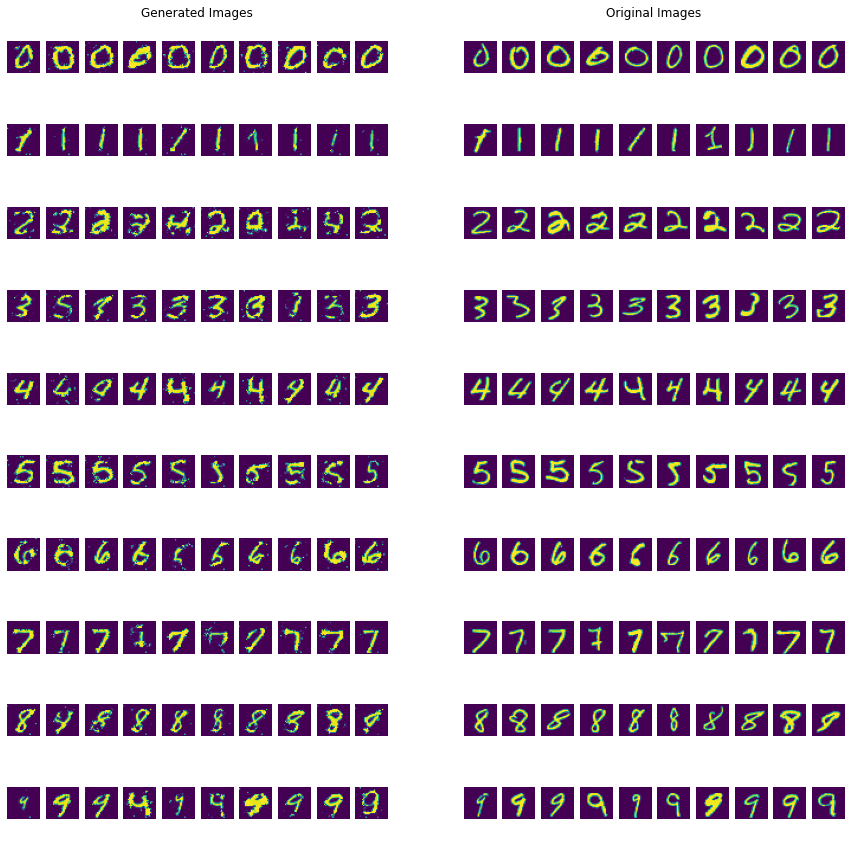

In [22]:
# https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
# https://matplotlib.org/3.1.0/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py

test_examples = test_examples.cpu().numpy()

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 15))

spec = gridspec.GridSpec(ncols=2, nrows=1, hspace=10)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax1.set_title("Generated Images")
ax2.set_title("Original Images")
ax1.axis('off')
ax2.axis('off')

left = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[0]) # plot for generated images
right = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=spec[1]) # plot for original images
for c in range(100):
    ax = plt.Subplot(fig, left[c])
    ax.imshow(generated_examples[c].squeeze())
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.add_subplot(ax)

    ax = plt.Subplot(fig, right[c])
    ax.imshow(test_examples[c].squeeze())
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.add_subplot(ax)
plt.show()

While these are not the best looking MNIST digits, the results seems similar to what prof. Kim got.